In [1]:
from pathlib import Path
import pandas as pd
import json
import re

DATA_ROOT = Path("/kaggle/input/first-impressions-v2-cvpr17-training")
assert DATA_ROOT.exists(), "Folder dataset tidak ditemukan. Tambahkan dataset ke Notebook dulu."

# **LOAD DATASET**


In [2]:
# -------------------------------
# 1) Kumpulkan path video
# -------------------------------
TRAIN_DIRS = sorted([p for p in DATA_ROOT.iterdir() 
                     if p.is_dir() and p.name.startswith("train-") and p.name.split("-")[-1].isdigit()])

VIDEO_EXTS = {".mp4", ".avi", ".mov", ".mkv"}
def list_videos(dirs):
    files = []
    for d in dirs:
        for ext in VIDEO_EXTS:
            files += list(d.rglob(f"*{ext}"))
    return files

video_files = list_videos(TRAIN_DIRS)
print(f"Jumlah folder train-*: {len(TRAIN_DIRS)}")
print(f"Jumlah video: {len(video_files)}")
print("Contoh:", [str(p.relative_to(DATA_ROOT)) for p in video_files[:3]])

# Buat map {stem -> fullpath} dan {relpath -> fullpath}
stem_map = {p.stem: p for p in video_files}
rel_map  = {str(p.relative_to(DATA_ROOT)).replace("\\","/"): p for p in video_files}


Jumlah folder train-*: 6
Jumlah video: 6000
Contoh: ['train-1/training80_04/JTmq4k4uQCY.002.mp4', 'train-1/training80_04/frsDpQjmC5k.002.mp4', 'train-1/training80_04/0Wr69VD_oXI.004.mp4']


In [3]:
# -------------------------------
# 2) Cari & Baca file anotasi (.pkl/.csv/.json)
# -------------------------------
import pickle
import numpy as np

ANN_DIR = DATA_ROOT / "train-annotation"
assert ANN_DIR.exists(), "Folder train-annotation tidak ditemukan."

def guess_labels_file(ann_dir: Path) -> Path:
    # Prioritas: PKL > CSV > JSON
    cands = (
        list(ann_dir.rglob("*.pkl")) +
        list(ann_dir.rglob("*.pickle")) +
        list(ann_dir.rglob("*.csv")) +
        list(ann_dir.rglob("*.json"))
    )
    keys = ("label","annotation","train","personality")
    good = [p for p in cands if any(k in p.name.lower() for k in keys)]
    return (good or cands)[0] if (good or cands) else None

labels_path = guess_labels_file(ANN_DIR)
assert labels_path is not None, "Tidak menemukan file label di train-annotation."
print("Labels file:", labels_path.name)

def load_pickle_any_encoding(path: Path):
    # Beberapa mirror FI memakai pickle Python2 -> coba latin1
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception:
        with open(path, "rb") as f:
            return pickle.load(f, encoding="latin1")

def load_labels_flex(path: Path) -> pd.DataFrame:
    suf = path.suffix.lower()
    if suf in (".pkl", ".pickle"):
        obj = load_pickle_any_encoding(path)
        # 1) Sudah DataFrame
        if isinstance(obj, pd.DataFrame):
            return obj

        # 2) List[dict] -> DataFrame langsung
        if isinstance(obj, list) and all(isinstance(x, dict) for x in obj):
            return pd.DataFrame(obj)

        # 3) Dict bentuk umum:
        #    a) {filename: {trait...}} 
        #    b) {"train": [{...}, ...]} 
        #    c) { "video": [...], "personality": [[...],[...], ...] }
        if isinstance(obj, dict):
            # b) ada key yg berisi list of dict
            for k, v in obj.items():
                if isinstance(v, list) and v and isinstance(v[0], dict):
                    return pd.DataFrame(v)

            # c) kolom paralel (list sama panjang)
            keys_list = [k for k,v in obj.items() if isinstance(v, (list, tuple, np.ndarray))]
            if keys_list:
                # Panjang harus sama
                lens = {len(v) for k,v in obj.items() if k in keys_list}
                if len(lens) == 1:
                    L = lens.pop()
                    rows = []
                    for i in range(L):
                        row = {}
                        for k,v in obj.items():
                            if isinstance(v, (list, tuple, np.ndarray)):
                                row[k] = v[i]
                        rows.append(row)
                    return pd.DataFrame(rows)

            # a) mapping filename -> dict / list
            if obj and all(isinstance(k, str) for k in obj.keys()):
                rows = []
                for fname, val in obj.items():
                    row = {"filename": fname}
                    if isinstance(val, dict):
                        row.update(val)
                    elif isinstance(val, (list, tuple, np.ndarray)) and len(val) == 5:
                        row["personality"] = list(val)
                    else:
                        row["value"] = val
                    rows.append(row)
                return pd.DataFrame(rows)

        # Jika tak terdeteksi, jadikan string representasi buat debug
        return pd.DataFrame({"_raw_repr": [repr(type(obj)), str(obj)[:500]]})

    elif suf == ".csv":
        return pd.read_csv(path)
    elif suf == ".json":
        with open(path, "r", encoding="utf-8") as f:
            obj = json.load(f)
        if isinstance(obj, list):
            return pd.DataFrame(obj)
        if isinstance(obj, dict):
            key = next((k for k,v in obj.items() if isinstance(v, list)), None)
            if key: return pd.DataFrame(obj[key])
        raise ValueError("Format JSON anotasi tidak dikenali.")
    else:
        raise ValueError(f"Ekstensi anotasi tidak didukung: {suf}")

labels_df = load_labels_flex(labels_path)
print("Kolom label asli:", list(labels_df.columns)[:20])
print("Contoh 3 baris anotasi:")
display(labels_df.head(10))

Labels file: annotation_training.pkl
Kolom label asli: ['filename', 'J4GQm9j0JZ0.003.mp4', 'zEyRyTnIw5I.005.mp4', 'nskJh7v6v1U.004.mp4', '6wHQsN5g2RM.000.mp4', 'dQOeQYWIgm8.000.mp4', 'eHcRre1YsNA.000.mp4', 'vZpneJlniAE.005.mp4', 'oANKg9_grdA.004.mp4', 'VuadgOz6T7s.000.mp4', '7nhJXn9PI0I.001.mp4', 'tEQEKN07KgQ.001.mp4', 'I5x9T9ftW18.005.mp4', 'dh6iOU2RtTA.003.mp4', 'gsleSGEZHAs.004.mp4', 'vhugKRUnd-c.001.mp4', 'kn6I8LdQFN0.004.mp4', 'M5_x5J-H2I0.003.mp4', 'w_ExyXsnw2A.000.mp4', 'DnTtbAR_Qyw.004.mp4']
Contoh 3 baris anotasi:


,filename,J4GQm9j0JZ0.003.mp4,zEyRyTnIw5I.005.mp4,nskJh7v6v1U.004.mp4,6wHQsN5g2RM.000.mp4,dQOeQYWIgm8.000.mp4,eHcRre1YsNA.000.mp4,vZpneJlniAE.005.mp4,oANKg9_grdA.004.mp4,VuadgOz6T7s.000.mp4,...,vOxgWKGNEYc.000.mp4,Y1LrgyCJtpU.001.mp4,leslBYwG8kc.002.mp4,qD15qWMepxU.003.mp4,EA8BEYAZqAA.004.mp4,Eh7WRYXVh9M.000.mp4,2q8orkMs2Jg.003.mp4,F1lAPYh4t3U.000.mp4,cxJ0u6r0-pU.001.mp4,hfUH9Am-Izs.000.mp4
0,extraversion,0.523364,0.345794,0.252336,0.457944,0.607477,0.196262,0.420561,0.429907,0.224299,...,0.364486,0.308411,0.588785,0.271028,0.822430,0.523364,0.728972,0.700935,0.317757,0.401869
1,neuroticism,0.552083,0.375000,0.291667,0.489583,0.489583,0.302083,0.635417,0.583333,0.135417,...,0.666667,0.343750,0.593750,0.427083,0.843750,0.479167,0.760417,0.770833,0.531250,0.500000
2,agreeableness,0.626374,0.472527,0.406593,0.505495,0.406593,0.351648,0.571429,0.626374,0.153846,...,0.560440,0.516484,0.714286,0.461538,0.813187,0.626374,0.582418,0.747253,0.582418,0.461538
3,conscientiousness,0.601942,0.582524,0.485437,0.398058,0.621359,0.262136,0.466019,0.582524,0.145631,...,0.689320,0.378641,0.514563,0.524272,0.796117,0.621359,0.524272,0.699029,0.679612,0.543689
4,interview,0.504673,0.457944,0.373832,0.457944,0.570093,0.214953,0.532710,0.551402,0.140187,...,0.532710,0.280374,0.663551,0.373832,0.813084,0.588785,0.616822,0.691589,0.616822,0.429907
5,openness,0.488889,0.366667,0.511111,0.377778,0.622222,0.566667,0.633333,0.588889,0.233333,...,0.622222,0.411111,0.577778,0.522222,0.955556,0.544444,0.822222,0.788889,0.588889,0.588889


In [4]:
# =============================
# Transpose label-matrix -> per-file row (Big Five klasik)
# rows (labels_df.index): ["extraversion","neuroticism","agreeableness","conscientiousness","interview","openness"]
# cols: ["J4GQm9j0JZ0.003.mp4", "zEyRyTnlw5I.005.mp4", ...]
# =============================

import pandas as pd
import numpy as np
from pathlib import Path

# 1) pastikan index = trait
if "filename" in labels_df.columns and labels_df.index.name != "trait":
    labels_df = labels_df.set_index("filename")
labels_df.index.name = "trait"

# 2) transpose -> baris = filename, kolom = trait
wide = labels_df.T.reset_index().rename(columns={"index": "filename"})

# 3) pastikan numerik
for c in wide.columns:
    if c != "filename":
        wide[c] = pd.to_numeric(wide[c], errors="coerce")

# 4) normalisasi nama kolom (TIDAK membuat emotional_stability)
#    kita tetap pakai 'neuroticism' sesuai Big Five
rename_map = {
    "extraversion": "extraversion",
    "agreeableness": "agreeableness",
    "conscientiousness": "conscientiousness",
    "openness": "openness",
}
wide = wide.rename(columns=rename_map)

# 5) id & group untuk GroupKFold
wide["raw_id"] = wide["filename"].astype(str)
wide["stem"] = wide["filename"].apply(lambda x: Path(x).stem)
wide["group_id"] = wide["stem"]

# 6) join ke path video yang sudah di-scan sebelumnya (pakai rel_map & stem_map)
def path_from_filename(fn: str):
    rel = fn.replace("\\", "/")
    if rel in rel_map:  # exact relpath match
        return rel_map[rel]
    st = Path(fn).stem
    if st in stem_map:  # match by stem
        return stem_map[st]
    return None

wide["path"] = wide["filename"].map(path_from_filename)
wide["relpath"] = wide["path"].apply(lambda p: str(p.relative_to(DATA_ROOT)).replace("\\","/") if isinstance(p, Path) else pd.NA)

# 7) pilih kolom final (pakai NEUROTICISM, tidak ada emotional_stability)
cols_order = [
    "raw_id","group_id","relpath",
    "extraversion","agreeableness","conscientiousness","neuroticism","openness",
]
meta_df = wide[[c for c in cols_order if c in wide.columns]].copy()

# (opsional) drop label interview kalau mau fokus 5 dimensi saja
# meta_df = meta_df.drop(columns=["invite_to_interview"], errors="ignore")

print("Rows per-file:", len(meta_df))
print("Ter-join ke video:", meta_df["relpath"].notna().sum())
display(meta_df.head(8))

# 8) simpan & overwrite meta CSV (hapus lama biar gak ke-load versi salah)
meta_out = Path("/kaggle/working/fi_v2_meta.csv")
meta_df.to_csv(meta_out, index=False)
print("Meta DISIMPAN (overwrite) ke:", meta_out)


Rows per-file: 6000
Ter-join ke video: 6000


trait,raw_id,group_id,relpath,extraversion,agreeableness,conscientiousness,neuroticism,openness
0,J4GQm9j0JZ0.003.mp4,J4GQm9j0JZ0.003,train-5/training80_60/J4GQm9j0JZ0.003.mp4,0.523364,0.626374,0.601942,0.552083,0.488889
1,zEyRyTnIw5I.005.mp4,zEyRyTnIw5I.005,train-6/training80_71/zEyRyTnIw5I.005.mp4,0.345794,0.472527,0.582524,0.375000,0.366667
2,nskJh7v6v1U.004.mp4,nskJh7v6v1U.004,train-5/training80_52/nskJh7v6v1U.004.mp4,0.252336,0.406593,0.485437,0.291667,0.511111
3,6wHQsN5g2RM.000.mp4,6wHQsN5g2RM.000,train-3/training80_36/6wHQsN5g2RM.000.mp4,0.457944,0.505495,0.398058,0.489583,0.377778
4,dQOeQYWIgm8.000.mp4,dQOeQYWIgm8.000,train-6/training80_70/dQOeQYWIgm8.000.mp4,0.607477,0.406593,0.621359,0.489583,0.622222
5,eHcRre1YsNA.000.mp4,eHcRre1YsNA.000,train-2/training80_14/eHcRre1YsNA.000.mp4,0.196262,0.351648,0.262136,0.302083,0.566667
6,vZpneJlniAE.005.mp4,vZpneJlniAE.005,train-5/training80_55/vZpneJlniAE.005.mp4,0.420561,0.571429,0.466019,0.635417,0.633333
7,oANKg9_grdA.004.mp4,oANKg9_grdA.004,train-5/training80_60/oANKg9_grdA.004.mp4,0.429907,0.626374,0.582524,0.583333,0.588889


Meta DISIMPAN (overwrite) ke: /kaggle/working/fi_v2_meta.csv


# **EDA**


Jumlah baris: 6000
Kolom: ['raw_id', 'group_id', 'relpath', 'extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness']


,raw_id,group_id,relpath,extraversion,agreeableness,conscientiousness,neuroticism,openness
0,J4GQm9j0JZ0.003.mp4,J4GQm9j0JZ0.003,train-5/training80_60/J4GQm9j0JZ0.003.mp4,0.523364,0.626374,0.601942,0.552083,0.488889
1,zEyRyTnIw5I.005.mp4,zEyRyTnIw5I.005,train-6/training80_71/zEyRyTnIw5I.005.mp4,0.345794,0.472527,0.582524,0.375000,0.366667
2,nskJh7v6v1U.004.mp4,nskJh7v6v1U.004,train-5/training80_52/nskJh7v6v1U.004.mp4,0.252336,0.406593,0.485437,0.291667,0.511111
3,6wHQsN5g2RM.000.mp4,6wHQsN5g2RM.000,train-3/training80_36/6wHQsN5g2RM.000.mp4,0.457944,0.505495,0.398058,0.489583,0.377778
4,dQOeQYWIgm8.000.mp4,dQOeQYWIgm8.000,train-6/training80_70/dQOeQYWIgm8.000.mp4,0.607477,0.406593,0.621359,0.489583,0.622222



Missing per trait: {'extraversion': 0, 'agreeableness': 0, 'conscientiousness': 0, 'neuroticism': 0, 'openness': 0}

Semua nilai Big Five berada dalam rentang [0,1].

Statistik deskriptif (Big Five):


,count,mean,std,min,25%,50%,75%,max
extraversion,6000.0,0.476146,0.152297,0.000000,0.373832,0.476636,0.588785,0.925234
agreeableness,6000.0,0.548181,0.136385,0.000000,0.461538,0.560440,0.637363,1.000000
conscientiousness,6000.0,0.522731,0.155219,0.000000,0.417476,0.524272,0.631068,0.970874
neuroticism,6000.0,0.520286,0.153546,0.020833,0.416667,0.531250,0.635417,0.979167
openness,6000.0,0.566281,0.146990,0.000000,0.466667,0.577778,0.666667,1.000000


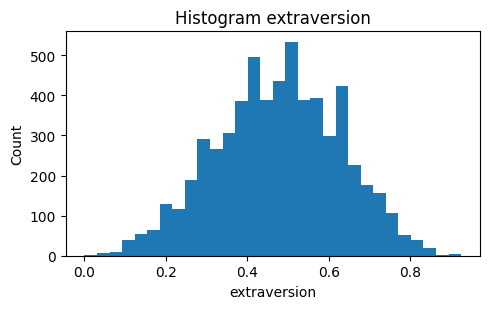

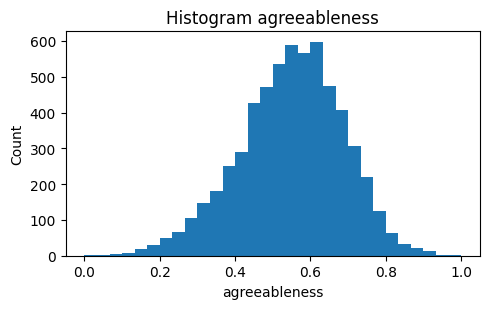

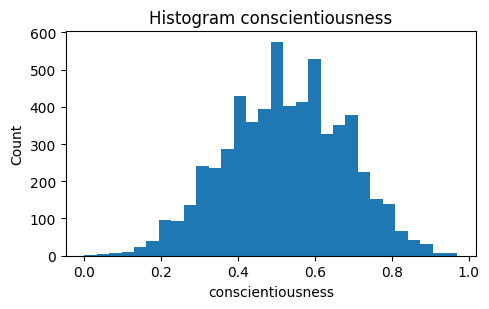

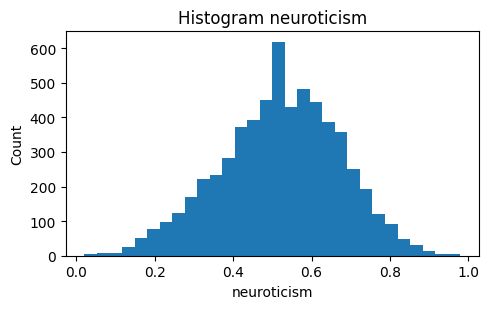

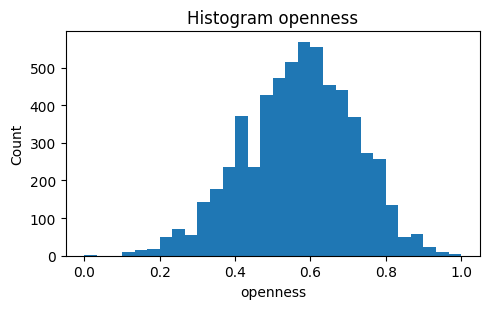


Matriks korelasi (signed):


,extraversion,agreeableness,conscientiousness,neuroticism,openness
extraversion,1.000000,0.710505,0.588592,0.796407,0.774249
agreeableness,0.710505,1.000000,0.657955,0.732660,0.649029
conscientiousness,0.588592,0.657955,1.000000,0.719671,0.582695
neuroticism,0.796407,0.732660,0.719671,1.000000,0.774219
openness,0.774249,0.649029,0.582695,0.774219,1.000000



Matriks korelasi (absolute):


,extraversion,agreeableness,conscientiousness,neuroticism,openness
extraversion,1.000000,0.710505,0.588592,0.796407,0.774249
agreeableness,0.710505,1.000000,0.657955,0.732660,0.649029
conscientiousness,0.588592,0.657955,1.000000,0.719671,0.582695
neuroticism,0.796407,0.732660,0.719671,1.000000,0.774219
openness,0.774249,0.649029,0.582695,0.774219,1.000000


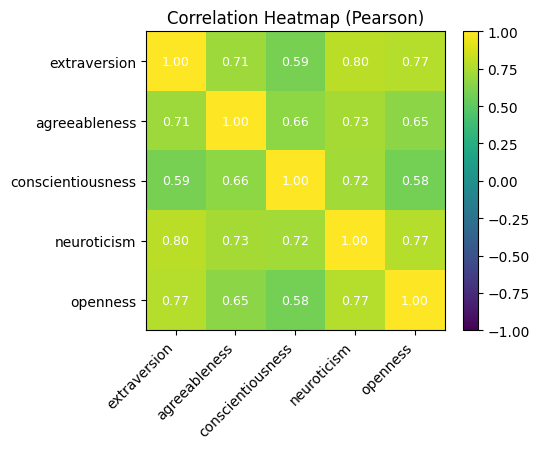

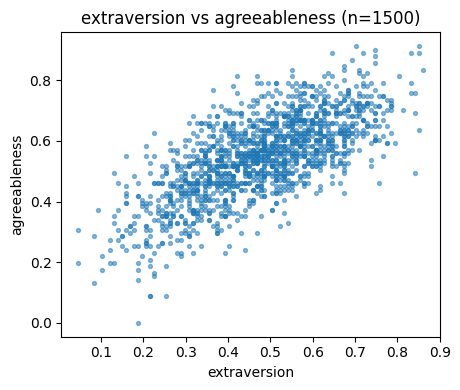

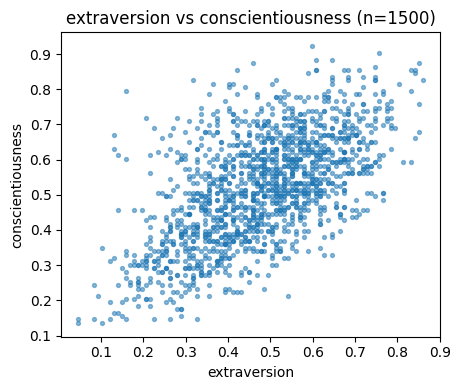

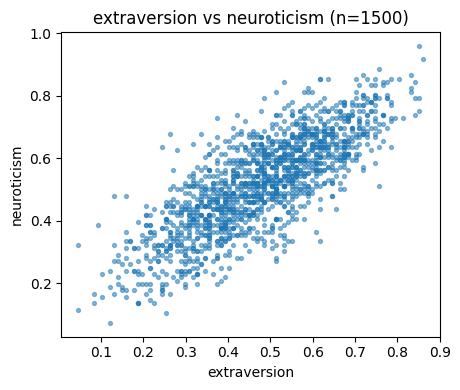

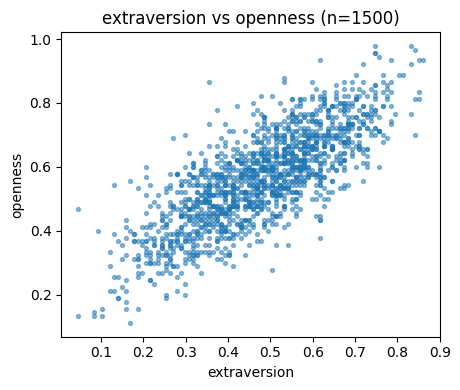

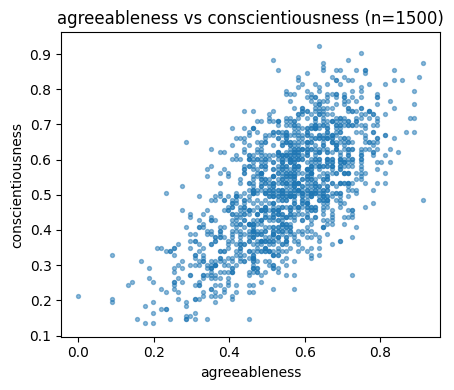

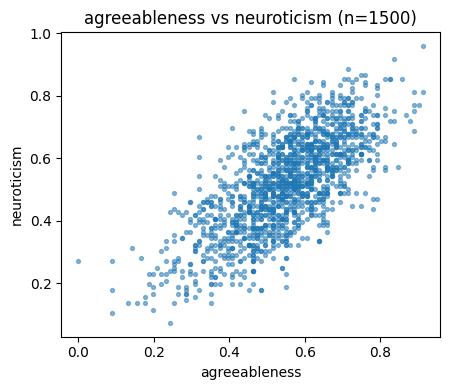

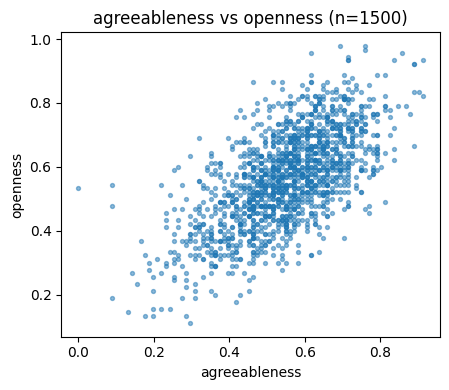

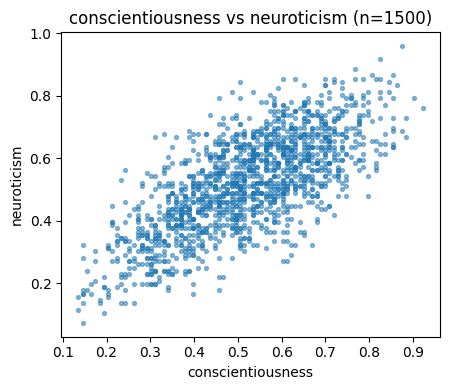

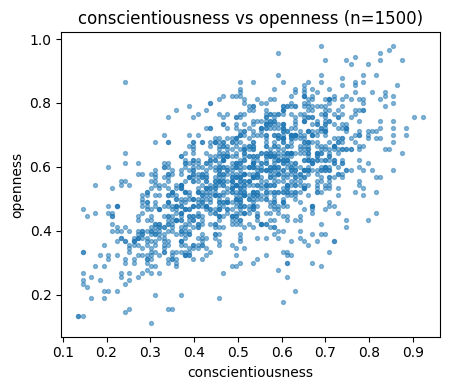

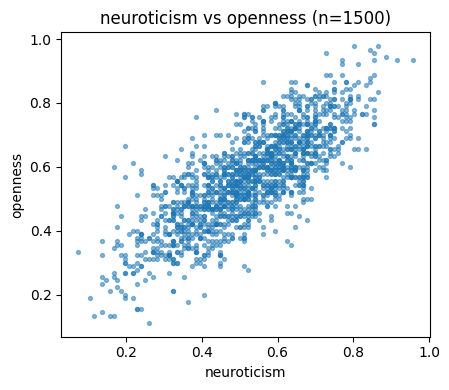


Distribusi ukuran group_id (top 10):


,n_clips
group_id,
zyGz_H1UTnQ.003,1
--Ymqszjv54.001,1
--Ymqszjv54.003,1
--Ymqszjv54.004,1
--Ymqszjv54.005,1
-2qsCrkXdWs.001,1
-55DRRMTppE.000,1
-55DRRMTppE.005,1
-5riMLK-PgU.001,1


Jumlah unik group_id: 6000
Rata-rata klip per group: 1.0


,fold,n,mean_extraversion,mean_agreeableness,mean_conscientiousness,mean_neuroticism,mean_openness
0,1,1200,0.469081,0.541273,0.520154,0.515469,0.561185
1,2,1200,0.478092,0.544267,0.521133,0.524123,0.568352
2,3,1200,0.481340,0.549853,0.524547,0.523316,0.566657
3,4,1200,0.477313,0.557015,0.528972,0.522196,0.570241
4,5,1200,0.474907,0.548498,0.518851,0.516328,0.564972


In [5]:
# ===============================
# EDA FI-V2 (Big Five klasik = termasuk neuroticism)
# ===============================
import os, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

WORK = Path("/kaggle/working")
META_PATH = WORK / "fi_v2_meta.csv"

# 1) Load meta_df (yang baru)
meta_df = pd.read_csv(META_PATH)

# 2) Kolom target
BIG5 = ["extraversion","agreeableness","conscientiousness","neuroticism","openness"]

print("Jumlah baris:", len(meta_df))
print("Kolom:", list(meta_df.columns))
display(meta_df.head())

# 3) Missing & out-of-range check
na_counts = meta_df[BIG5].isna().sum().to_dict()
print("\nMissing per trait:", na_counts)

def out_of_range_mask(df, cols, lo=0.0, hi=1.0):
    m = pd.DataFrame(False, index=df.index, columns=cols)
    for c in cols:
        m[c] = (df[c] < lo) | (df[c] > hi)
    return m

oor = out_of_range_mask(meta_df, BIG5, 0.0, 1.0)
if oor.any().any():
    print("\nWARNING: Ada nilai label di luar [0,1]. Contoh index/trait:")
    print(oor.stack()[oor.stack()].index.tolist()[:20])
else:
    print("\nSemua nilai Big Five berada dalam rentang [0,1].")

# 4) Statistik deskriptif
print("\nStatistik deskriptif (Big Five):")
display(meta_df[BIG5].describe().T)

# 5) Histogram per trait
figdir = WORK / "fig"
figdir.mkdir(exist_ok=True)

for c in BIG5:
    plt.figure(figsize=(5,3.2))
    plt.hist(meta_df[c].dropna(), bins=30)
    plt.title(f"Histogram {c}")
    plt.xlabel(c); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(figdir / f"hist_{c}.png", dpi=120)
    plt.show()

# 6) Korelasi Pearson (+ absolute untuk melihat kekuatan hubungan)
corr = meta_df[BIG5].corr(method="pearson")
corr_abs = corr.abs()
print("\nMatriks korelasi (signed):"); display(corr)
print("\nMatriks korelasi (absolute):"); display(corr_abs)

plt.figure(figsize=(6,4.6))
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(range(len(BIG5)), BIG5, rotation=45, ha="right")
plt.yticks(range(len(BIG5)), BIG5)
plt.title("Correlation Heatmap (Pearson)")
for i in range(len(BIG5)):
    for j in range(len(BIG5)):
        v = corr.iloc[i,j]
        plt.text(j, i, f"{v:.2f}", ha="center", va="center",
                 color=("white" if abs(v)>0.5 else "black"), fontsize=9)
plt.tight_layout()
plt.savefig(figdir / "corr_heatmap_signed.png", dpi=140)
plt.show()

# 7) Pairwise scatter (sample biar ringan)
SAMPLE_N = min(1500, len(meta_df))
sample_df = meta_df.sample(SAMPLE_N, random_state=42)[BIG5].dropna()

pairs = [(i,j) for i in range(len(BIG5)) for j in range(i+1, len(BIG5))]
for i, j in pairs:
    x, y = BIG5[i], BIG5[j]
    plt.figure(figsize=(4.6,4.0))
    plt.scatter(sample_df[x], sample_df[y], s=8, alpha=0.5)
    plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} vs {y} (n={len(sample_df)})")
    plt.tight_layout()
    plt.savefig(figdir / f"scatter_{x}_vs_{y}.png", dpi=120)
    plt.show()

# 8) Analisis group_id (anti-leakage)
if "group_id" in meta_df.columns:
    grp_counts = meta_df.groupby("group_id").size().sort_values(ascending=False)
    print("\nDistribusi ukuran group_id (top 10):")
    display(grp_counts.head(10).to_frame("n_clips"))
    print("Jumlah unik group_id:", grp_counts.shape[0])
    print("Rata-rata klip per group:", float(grp_counts.mean()))
    dup_groups = grp_counts[grp_counts > 1].index
    if len(dup_groups):
        print(f"Groups dengan >1 klip: {len(dup_groups)} (ingat: wajib GroupKFold).")
else:
    print("\nKolom group_id tidak ada. Disarankan menambahkannya dari stem/youtube_id.")

# 9) Contoh GroupKFold 5-fold + keseimbangan label per fold
from sklearn.model_selection import GroupKFold

if "group_id" in meta_df.columns:
    valid = meta_df.dropna(subset=BIG5).reset_index(drop=True)
    groups = valid["group_id"].astype(str).values
    gkf = GroupKFold(n_splits=5)

    fold_stats = []
    for fold, (_, val_idx) in enumerate(gkf.split(valid, groups=groups), 1):
        val_part = valid.iloc[val_idx]
        mean_vals = val_part[BIG5].mean().to_dict()
        fold_stats.append({"fold": fold, "n": len(val_part), **{f"mean_{k}": v for k,v in mean_vals.items()}})
    display(pd.DataFrame(fold_stats))
else:
    print("\nLewati GroupKFold: group_id tidak tersedia.")


# **ETL ( EXTRACT, TRANSFORM, LOAD)**


In [6]:
# --- Konversi video -> WAV 16k mono dengan progress & fail counter ---
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import os, subprocess
import pandas as pd
from pathlib import Path

DATA_ROOT = Path("/kaggle/input/first-impressions-v2-cvpr17-training")
WORK      = Path("/kaggle/working")
META_PATH = WORK / "fi_v2_meta.csv"
WAV_DIR   = WORK / "wav"
WAV_DIR.mkdir(exist_ok=True, parents=True)

meta_df = pd.read_csv(META_PATH)

def to_wav(out_dir: Path, relpath: str) -> str | None:
    if not isinstance(relpath, str) or not relpath:
        return None
    src = DATA_ROOT / relpath
    if not src.exists():
        return None
    stem = Path(relpath).stem
    dst = out_dir / f"{stem}.wav"
    if dst.exists():
        return str(dst)
    cmd = [
        "ffmpeg", "-nostdin", "-hide_banner", "-y",
        "-i", str(src),
        "-ac", "1", "-ar", "16000", "-vn",
        "-sample_fmt", "s16",
        "-loglevel", "error",  # hanya error
        str(dst),
    ]
    try:
        subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
        return str(dst)
    except Exception:
        return None

# hanya submit yang relpath-nya valid
idx_rel = [(i, p) for i, p in enumerate(meta_df["relpath"].tolist()) if isinstance(p, str)]
results = [None] * len(meta_df)
fail = 0

max_workers = min(8, os.cpu_count() or 2)

with ThreadPoolExecutor(max_workers=max_workers) as ex:
    fut2idx = {ex.submit(to_wav, WAV_DIR, p): i for i, p in idx_rel}
    pbar = tqdm(as_completed(fut2idx), total=len(fut2idx), desc="Converting to WAV", unit="file")
    for fut in pbar:
        i = fut2idx[fut]
        try:
            outp = fut.result()
        except Exception:
            outp = None
        results[i] = outp
        if outp is None:
            fail += 1
        pbar.set_postfix_str(f"failed={fail}")

meta_df["wav_path"] = results
ok = meta_df["wav_path"].notna().sum()
print(f"WAV created: {ok}/{len(idx_rel)} | failed={fail}")

meta_df.to_csv(META_PATH, index=False)
print("Updated:", META_PATH)


Converting to WAV:   0%|          | 0/6000 [00:00<?, ?file/s]

WAV created: 6000/6000 | failed=0
Updated: /kaggle/working/fi_v2_meta.csv


In [7]:
display(meta_df.head(8))

,raw_id,group_id,relpath,extraversion,agreeableness,conscientiousness,neuroticism,openness,wav_path
0,J4GQm9j0JZ0.003.mp4,J4GQm9j0JZ0.003,train-5/training80_60/J4GQm9j0JZ0.003.mp4,0.523364,0.626374,0.601942,0.552083,0.488889,/kaggle/working/wav/J4GQm9j0JZ0.003.wav
1,zEyRyTnIw5I.005.mp4,zEyRyTnIw5I.005,train-6/training80_71/zEyRyTnIw5I.005.mp4,0.345794,0.472527,0.582524,0.375000,0.366667,/kaggle/working/wav/zEyRyTnIw5I.005.wav
2,nskJh7v6v1U.004.mp4,nskJh7v6v1U.004,train-5/training80_52/nskJh7v6v1U.004.mp4,0.252336,0.406593,0.485437,0.291667,0.511111,/kaggle/working/wav/nskJh7v6v1U.004.wav
3,6wHQsN5g2RM.000.mp4,6wHQsN5g2RM.000,train-3/training80_36/6wHQsN5g2RM.000.mp4,0.457944,0.505495,0.398058,0.489583,0.377778,/kaggle/working/wav/6wHQsN5g2RM.000.wav
4,dQOeQYWIgm8.000.mp4,dQOeQYWIgm8.000,train-6/training80_70/dQOeQYWIgm8.000.mp4,0.607477,0.406593,0.621359,0.489583,0.622222,/kaggle/working/wav/dQOeQYWIgm8.000.wav
5,eHcRre1YsNA.000.mp4,eHcRre1YsNA.000,train-2/training80_14/eHcRre1YsNA.000.mp4,0.196262,0.351648,0.262136,0.302083,0.566667,/kaggle/working/wav/eHcRre1YsNA.000.wav
6,vZpneJlniAE.005.mp4,vZpneJlniAE.005,train-5/training80_55/vZpneJlniAE.005.mp4,0.420561,0.571429,0.466019,0.635417,0.633333,/kaggle/working/wav/vZpneJlniAE.005.wav
7,oANKg9_grdA.004.mp4,oANKg9_grdA.004,train-5/training80_60/oANKg9_grdA.004.mp4,0.429907,0.626374,0.582524,0.583333,0.588889,/kaggle/working/wav/oANKg9_grdA.004.wav


Measuring durations:   0%|          | 0/6000 [00:00<?, ?file/s]

Saved with duration_sec -> /kaggle/working/fi_v2_meta.csv

=== Duration stats (seconds) ===
count    6000.000
mean       15.271
std         0.467
min         2.067
1%         15.302
5%         15.302
10%        15.302
25%        15.302
50%        15.302
75%        15.302
90%        15.302
95%        15.302
99%        15.302
max        15.302
Name: duration_sec, dtype: float64


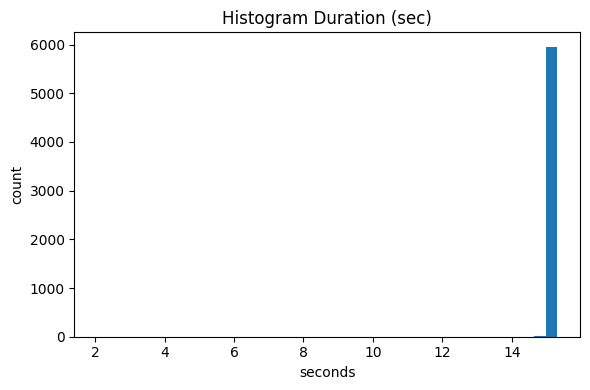

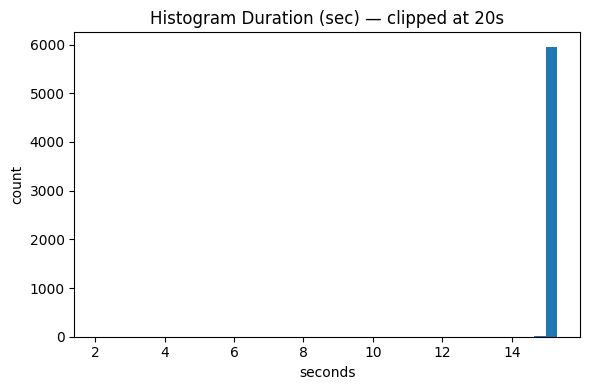


Too short (<4.0s): 3 rows
                   raw_id  duration_sec
3370  r93dLeVRk3U.003.mp4      2.925750
3936  XpY-cxkbYdo.002.mp4      3.900938
5644  39o1zJFeM7E.004.mp4      2.066563

Too long (>30.0s): 0 rows
Empty DataFrame
Columns: [raw_id, duration_sec]
Index: []


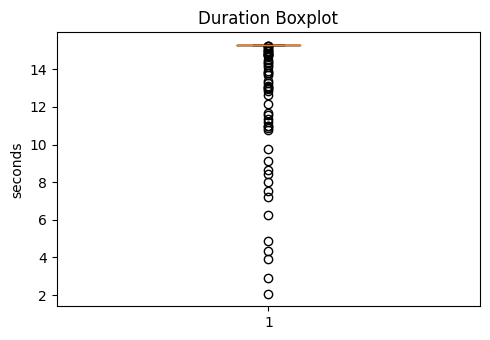

In [8]:
# === Analisis durasi WAV ===
import json, subprocess, numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

WORK      = Path("/kaggle/working")
META_PATH = WORK / "fi_v2_meta.csv"

meta_df = pd.read_csv(META_PATH)

def get_duration_seconds(path_str: str) -> float:
    if not isinstance(path_str, str):
        return np.nan
    p = Path(path_str)
    if not p.exists():
        return np.nan
    cmd = [
        "ffprobe", "-v", "error",
        "-show_entries", "format=duration",
        "-of", "json", str(p)
    ]
    try:
        out = subprocess.check_output(cmd)
        info = json.loads(out)
        return float(info.get("format", {}).get("duration", np.nan))
    except Exception:
        return np.nan

# Hitung durasi dengan progress bar (hanya untuk baris yang punya wav_path)
dur = meta_df["wav_path"].copy()
dur = [get_duration_seconds(x) for x in tqdm(dur, desc="Measuring durations", unit="file")]

meta_df["duration_sec"] = dur
meta_df.to_csv(META_PATH, index=False)
print("Saved with duration_sec ->", META_PATH)

# Ringkasan statistik
valid = meta_df["duration_sec"].dropna()
print("\n=== Duration stats (seconds) ===")
print(valid.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]).round(3))

# Histogram
plt.figure(figsize=(6,4))
plt.hist(valid, bins=40)
plt.title("Histogram Duration (sec)")
plt.xlabel("seconds"); plt.ylabel("count")
plt.tight_layout()
plt.show()

# (Opsional) histogram zoom range 0–20s agar lebih informatif
plt.figure(figsize=(6,4))
plt.hist(valid.clip(upper=20), bins=40)
plt.title("Histogram Duration (sec) — clipped at 20s")
plt.xlabel("seconds"); plt.ylabel("count")
plt.tight_layout()
plt.show()

# Deteksi outlier sederhana
MIN_SEC = 4.0     # gate pendek (ubah sesuai kebutuhan)
MAX_SEC = 30.0    # gate panjang (opsional, tergantung distribusi)
too_short = meta_df[meta_df["duration_sec"].fillna(0) < MIN_SEC]
too_long  = meta_df[meta_df["duration_sec"].fillna(0) > MAX_SEC]

print(f"\nToo short (<{MIN_SEC}s): {len(too_short)} rows")
print(too_short[["raw_id","duration_sec"]].head(10))

print(f"\nToo long (>{MAX_SEC}s): {len(too_long)} rows")
print(too_long[["raw_id","duration_sec"]].head(10))

# (Opsional) Boxplot cepat
plt.figure(figsize=(5,3.5))
plt.boxplot(valid, vert=True, showfliers=True)
plt.ylabel("seconds")
plt.title("Duration Boxplot")
plt.tight_layout()
plt.show()


Measuring durations:   0%|          | 0/6000 [00:00<?, ?it/s]

Problem rows: 3


,raw_id,relpath,wav_path,duration_sec
3370,r93dLeVRk3U.003.mp4,train-1/training80_03/r93dLeVRk3U.003.mp4,/kaggle/working/wav/r93dLeVRk3U.003.wav,2.925750
3936,XpY-cxkbYdo.002.mp4,train-2/training80_18/XpY-cxkbYdo.002.mp4,/kaggle/working/wav/XpY-cxkbYdo.002.wav,3.900938
5644,39o1zJFeM7E.004.mp4,train-4/training80_43/39o1zJFeM7E.004.mp4,/kaggle/working/wav/39o1zJFeM7E.004.wav,2.066563


Re-convert bad rows:   0%|          | 0/3 [00:00<?, ?file/s]

Re-measure durations:   0%|          | 0/3 [00:00<?, ?file/s]

Re-saved fixed meta -> /kaggle/working/fi_v2_meta.csv

Kept: 5997 rows  |  Rejected: 3 rows
Saved -> /kaggle/working/fi_v2_meta.clean.csv
Saved -> /kaggle/working/rejected.by_duration.csv

=== Duration after gate ===
count    5997.000
mean       15.277
std         0.377
min         4.319
1%         15.302
5%         15.302
10%        15.302
25%        15.302
50%        15.302
75%        15.302
90%        15.302
95%        15.302
99%        15.302
max        15.302
Name: duration_sec, dtype: float64


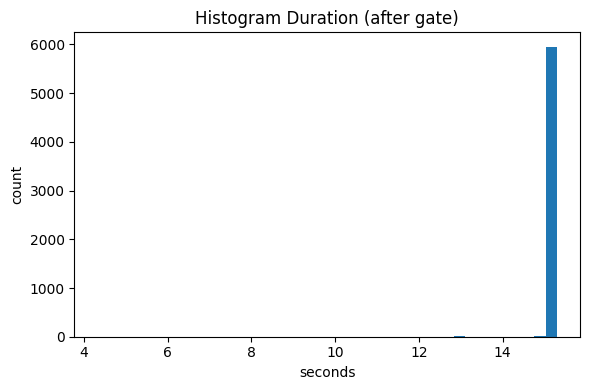

In [9]:
# === Fix & Gate by Duration (FI-V2) ===
import os, json, subprocess
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

# Paths
DATA_ROOT = Path("/kaggle/input/first-impressions-v2-cvpr17-training")
WORK      = Path("/kaggle/working")
META_PATH = WORK / "fi_v2_meta.csv"
WAV_DIR   = WORK / "wav"

# Gate thresholds
MIN_SEC = 4.0   # drop jika < MIN_SEC
MAX_SEC = 30.0  # praktis tak terpakai di FI-V2, tapi kita simpan saja

# --- Helpers ---
def ffmpeg_to_wav(src_rel: str) -> str | None:
    """Convert single video -> wav 16k mono s16. Return dst path or None on fail."""
    if not isinstance(src_rel, str) or not src_rel:
        return None
    src = DATA_ROOT / src_rel
    if not src.exists():
        return None
    dst = WAV_DIR / (Path(src_rel).stem + ".wav")
    if dst.exists():
        return str(dst)
    cmd = [
        "ffmpeg","-nostdin","-hide_banner","-y",
        "-i", str(src),
        "-ac","1","-ar","16000","-vn",
        "-sample_fmt","s16",
        "-loglevel","error",
        str(dst),
    ]
    try:
        subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
        return str(dst)
    except Exception:
        return None

def ffprobe_duration(path_str: str) -> float:
    """Return duration in seconds using ffprobe, or NaN if not available."""
    if not isinstance(path_str, str):
        return np.nan
    p = Path(path_str)
    if not p.exists():
        return np.nan
    cmd = ["ffprobe","-v","error","-show_entries","format=duration","-of","json", str(p)]
    try:
        out = subprocess.check_output(cmd)
        info = json.loads(out)
        return float(info.get("format", {}).get("duration", np.nan))
    except Exception:
        return np.nan

# --- Load meta ---
meta_df = pd.read_csv(META_PATH)

# 1) Measure (or re-measure) duration for all rows that have wav_path
tqdm.pandas(desc="Measuring durations")
meta_df["duration_sec"] = meta_df["wav_path"].progress_apply(ffprobe_duration)

# 2) Mark problem rows (NaN / too short / too long)
is_bad = meta_df["duration_sec"].isna() | (meta_df["duration_sec"] < MIN_SEC) | (meta_df["duration_sec"] > MAX_SEC)
bad_df = meta_df[is_bad].copy()
print(f"Problem rows: {len(bad_df)}")
display(bad_df[["raw_id","relpath","wav_path","duration_sec"]].head(10))

# 3) Re-convert videos for problem rows (might fix NaN or too short due to prior fail)
if len(bad_df):
    max_workers = min(8, os.cpu_count() or 2)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        fut2idx = {ex.submit(ffmpeg_to_wav, row["relpath"]): i for i, row in bad_df.iterrows()}
        for fut in tqdm(as_completed(fut2idx), total=len(fut2idx), desc="Re-convert bad rows", unit="file"):
            i = fut2idx[fut]
            try:
                new_path = fut.result()
            except Exception:
                new_path = None
            if new_path:
                meta_df.at[i, "wav_path"] = new_path

    # re-measure duration for those rows
    for i in tqdm(bad_df.index, desc="Re-measure durations", unit="file"):
        meta_df.at[i, "duration_sec"] = ffprobe_duration(meta_df.at[i, "wav_path"])

# 4) Save fixed meta
meta_df.to_csv(META_PATH, index=False)
print("Re-saved fixed meta ->", META_PATH)

# 5) Apply gate to produce clean vs rejected CSVs
keep_mask = meta_df["wav_path"].notna() & meta_df["duration_sec"].notna() & \
            (meta_df["duration_sec"] >= MIN_SEC) & (meta_df["duration_sec"] <= MAX_SEC)

kept = meta_df[keep_mask].reset_index(drop=True)
rej  = meta_df[~keep_mask].reset_index(drop=True)

kept_path = WORK / "fi_v2_meta.clean.csv"
rej_path  = WORK / "rejected.by_duration.csv"
kept.to_csv(kept_path, index=False)
rej.to_csv(rej_path, index=False)

print(f"\nKept: {len(kept)} rows  |  Rejected: {len(rej)} rows")
print("Saved ->", kept_path)
print("Saved ->", rej_path)

# 6) Quick summary & histogram after gate
valid = kept["duration_sec"].dropna()
print("\n=== Duration after gate ===")
print(valid.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]).round(3))

plt.figure(figsize=(6,4))
plt.hist(valid, bins=40)
plt.title("Histogram Duration (after gate)")
plt.xlabel("seconds"); plt.ylabel("count")
plt.tight_layout()
plt.show()


In [10]:
# === Hitung durasi ucapan efektif & voiced_ratio ===
import numpy as np, pandas as pd, librosa
from pathlib import Path
from tqdm.auto import tqdm

CLEAN_PATH = Path("/kaggle/working/fi_v2_meta.clean.csv")
df = pd.read_csv(CLEAN_PATH)

def speech_stats(path, sr=16000, frame_ms=30, hop_ms=15, rel_thresh=0.5, min_speech_ms=120):
    """
    Energy-based VAD sederhana:
    - frame_ms/hop_ms: ukuran & lompatan frame
    - rel_thresh: ambang relatif terhadap median energi (0.5–0.8 umum)
    - min_speech_ms: gabungkan segmen voiced yang sangat pendek (de-click)
    Return: effective_sec, voiced_ratio, rms_db_median
    """
    try:
        y, sr = librosa.load(path, sr=sr, mono=True)
        if len(y) == 0:
            return np.nan, np.nan, np.nan
        # RMS per frame
        frame = int(sr * frame_ms / 1000)
        hop   = int(sr * hop_ms / 1000)
        rms = librosa.feature.rms(y=y, frame_length=frame, hop_length=hop, center=True).flatten()
        rms_med = np.median(rms)
        thr = max(1e-8, rms_med * rel_thresh)
        voiced = rms > thr

        # optional: merge tiny gaps (closing holes)
        min_frames = max(1, int((min_speech_ms/1000) / (hop/sr)))
        # forward fill small gaps
        i = 0
        while i < len(voiced):
            if voiced[i]:
                j = i
                while j < len(voiced) and voiced[j]:
                    j += 1
                # voiced run [i, j)
                i = j
            else:
                # unvoiced run
                j = i
                while j < len(voiced) and not voiced[j]:
                    j += 1
                if j - i <= min_frames:
                    voiced[i:j] = True
                i = j

        eff_sec = voiced.sum() * hop / sr
        ratio = float(voiced.sum()) / float(len(voiced))
        # median RMS in dB
        rms_db_med = 20 * np.log10(rms_med + 1e-12)
        return eff_sec, ratio, rms_db_med
    except Exception:
        return np.nan, np.nan, np.nan

tqdm.pandas(desc="Computing speech stats")
stats = df["wav_path"].progress_apply(lambda p: speech_stats(p))
df[["speech_sec","voiced_ratio","rms_db_median"]] = pd.DataFrame(stats.tolist(), index=df.index)

# Threshold rekomendasi
MIN_SPEECH_SEC = 6.0       # 5–8 s umum; pilih 6 s sebagai kompromi
MIN_VOICED_R   = 0.35      # 35% dari total durasi voiced
MIN_RMS_DB     = -40.0     # buang klip terlalu pelan

mask_keep = (
    df["speech_sec"].fillna(0) >= MIN_SPEECH_SEC
) & (
    df["voiced_ratio"].fillna(0) >= MIN_VOICED_R
) & (
    df["rms_db_median"].fillna(-120) >= MIN_RMS_DB
)

kept = df[mask_keep].reset_index(drop=True)
rej  = df[~mask_keep].reset_index(drop=True)

print(f"Kept by speech stats: {len(kept)} | Rejected: {len(rej)}")
kept.to_csv("/kaggle/working/fi_v2_meta.speechclean.csv", index=False)
rej.to_csv("/kaggle/working/rejected.by_speech.csv", index=False)

# Ringkasan cepat
print(kept[["speech_sec","voiced_ratio","rms_db_median"]].describe().round(3))


Computing speech stats:   0%|          | 0/5997 [00:00<?, ?it/s]

Kept by speech stats: 5349 | Rejected: 648
       speech_sec  voiced_ratio  rms_db_median
count    5349.000      5349.000       5349.000
mean       12.330         0.806        -28.230
std         1.334         0.086          5.684
min         6.900         0.547        -39.991
25%        11.445         0.747        -32.429
50%        12.300         0.804        -28.138
75%        13.125         0.858        -24.028
max        15.315         1.000         -5.932
